<a href="https://colab.research.google.com/github/katyaserg/Text-mining/blob/main/Hate_speech_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate speech detection

In [1]:
import numpy as np
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.language import Language
from tqdm import tqdm

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
raw_file = '/content/drive/My Drive/Dynamically Generated Hate Dataset v0.2.3.csv'
clean_file = '/content/drive/My Drive/Dynamically Generated Hate Dataset v0.2.3 clean.csv'

Mounted at /content/drive


## Data preprocessing

In [3]:
raw_df = pd.read_csv(raw_file).iloc[:, 1:]
raw_df.head()

,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,acl1000,4,I'm not saying we should actually eliminate heebs.. I just wish they naturally became extinct,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN


In [4]:
nlp = spacy.load("en_core_web_sm")

# Define a custom pipeline component for text preprocessing
@spacy.Language.component("preprocess_text")
def preprocess_text(doc):
    # Convert spaCy Doc to plain text
    text = doc.text
    text = re.sub(r'http\S+', '', text)  # Removing URLs
    text = re.sub(r'<.*?>', '', text)    # Removing HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Removing special characters and digits

    text = text.lower()
    # Create a new spaCy Doc from the cleaned text
    return nlp.make_doc(text)

# Add the custom component to the spaCy pipeline
nlp.add_pipe("preprocess_text", last=True)


raw_file_name = '/content/drive/My Drive/Dynamically Generated Hate Dataset v0.2.3.csv'
output_file_name = '/content/drive/My Drive/Processed Hate Dataset v0.2.3.csv'


raw_df = pd.read_csv(raw_file_name)

# Process the 'text' column using spaCy's nlp.pipe
texts = raw_df["text"].astype(str).tolist()  # Ensure text column contains strings
processed_texts = [doc.text for doc in nlp.pipe(texts, batch_size=50)]

# Add the processed text to the DataFrame
raw_df["clean_text"] = processed_texts

In [5]:
raw_df.to_csv(output_file_name, index=False, header=True)

## Read the data

In [6]:
df = pd.read_csv(output_file_name, encoding="utf-8", engine="python")

In [7]:
from IPython.display import display

df["clean_text"] = df["clean_text"].fillna("")
df["is_hate"] = df["label"].apply(lambda x: 1 if x == "hate" else 0)
# Calculate the number of tokens in each row of the 'clean_text' column
df["tokens_count"] = df["clean_text"].apply(lambda x: len(x.split()))
display(df.head())

,Unnamed: 0,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched,clean_text,is_hate,tokens_count
0,1,acl1,1.0,dalits are lowlives,hate,notgiven,notgiven,original,train,1.0,GNZuCtwed3,1,NaN,dalits are lowlives,1,3
1,2,acl10,2.0,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1.0,GNZuCtwed3,1,NaN,gay people are a burden to our society,1,8
2,3,acl100,3.0,Arabs are not welcome,hate,notgiven,notgiven,original,train,1.0,vDe7GN0NrL,1,NaN,arabs are not welcome,1,4
3,4,acl1000,4.0,I'm not saying we should actually eliminate heebs.. I just wish they naturally became extinct,hate,notgiven,notgiven,original,train,1.0,oemYWm1Tjg,1,NaN,im not saying we should actually eliminate heebs i just wish they naturally became extinct,1,15
4,5,acl10000,5.0,bananas are for black people,hate,notgiven,notgiven,original,test,1.0,QiOKkCi7F8,1,NaN,bananas are for black people,1,5


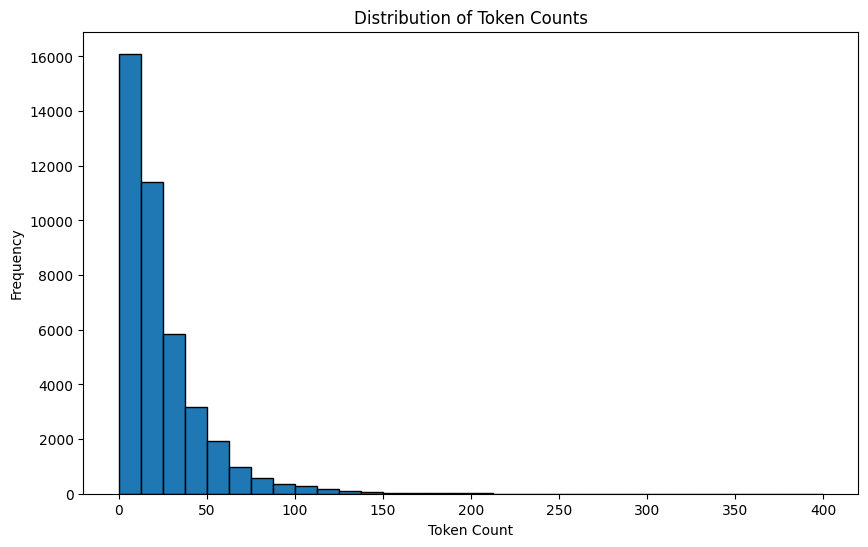

In [8]:
# Calculate the frequency distribution of token counts
token_count_distribution = df["tokens_count"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.hist(df["tokens_count"], bins=32, edgecolor='black')
plt.title("Distribution of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

## Wordcloud

Let's draw a simple wordcloud for text which is considered as Hate and Not

In [9]:
# Filter and extract the 'clean_text' column for non-hate and hate labels
non_hate_texts = df.loc[df["label"] == "nothate", "clean_text"]
hate_texts = df.loc[df["label"] == "hate", "clean_text"]

# Combine all entries in each series into single strings for word clouds
text_nothate = " ".join(non_hate_texts)
text_hate = " ".join(hate_texts)

# Define the function to generate and display the word cloud
def get_wordcloud(text, title=""):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

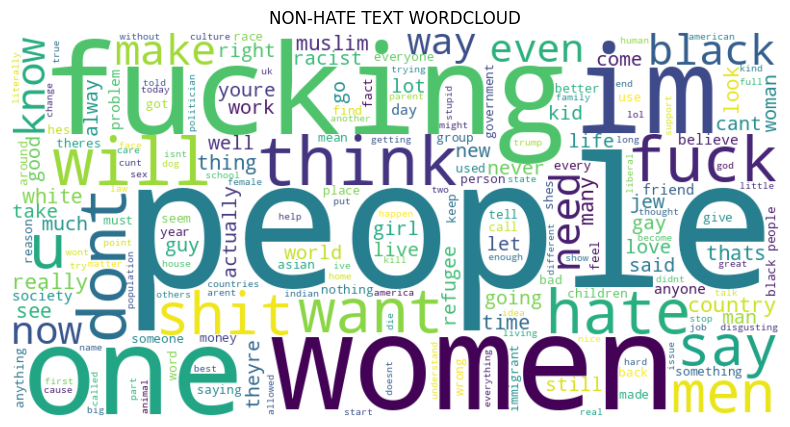

In [ ]:
get_wordcloud(text_nothate, "NON-HATE TEXT WORDCLOUD")

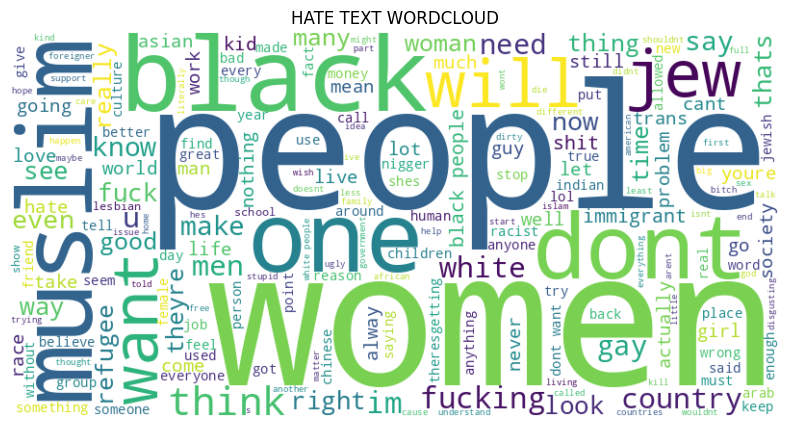

In [ ]:
get_wordcloud(text_hate, "HATE TEXT WORDCLOUD")

## Simple TF-IDF

In [10]:
# Train-test split and TF-IDF vectorization
vectorizer = TfidfVectorizer()
target = df['is_hate']
X_raw_train, X_raw_test, y_train, y_test = train_test_split(df["clean_text"], target, test_size=0.3, random_state=42)

# transforming text data into TF-IDF vectors
X_train = vectorizer.fit_transform(X_raw_train)
X_test = vectorizer.transform(X_raw_test)

In [11]:
# Define the evaluation function for logistic regression with varying regularization strengths
def evaluate_lr_with_different_reg(X_train, X_test, y_train, y_test, reg_values):
    training_accuracy, testing_accuracy = [], []
    for c_value in reg_values:
        lr_model = LogisticRegression(C=c_value, max_iter=1000, solver='lbfgs')
        lr_model.fit(X_train, y_train)

        # Record training and testing accuracy for each regularization strength
        training_accuracy.append(accuracy_score(y_train, lr_model.predict(X_train)))
        testing_accuracy.append(accuracy_score(y_test, lr_model.predict(X_test)))
    return training_accuracy, testing_accuracy

# Setting a range of regularization strengths and evaluating logistic regression models
regularization_values = np.logspace(-5, 3, 10)
train_acc, test_acc = evaluate_lr_with_different_reg(X_train, X_test, y_train, y_test, regularization_values)

# accuracy vs. regularization strength
def plot_accuracy_vs_regularization(reg_values, train_acc, test_acc):
    plt.figure()
    plt.grid()
    sns.lineplot(x=reg_values, y=train_acc, label="Training Accuracy")
    sns.lineplot(x=reg_values, y=test_acc, label="Testing Accuracy")
    plt.xscale('log')
    plt.xlabel("Inverse Regularization Strength (C)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Regularization Strength")

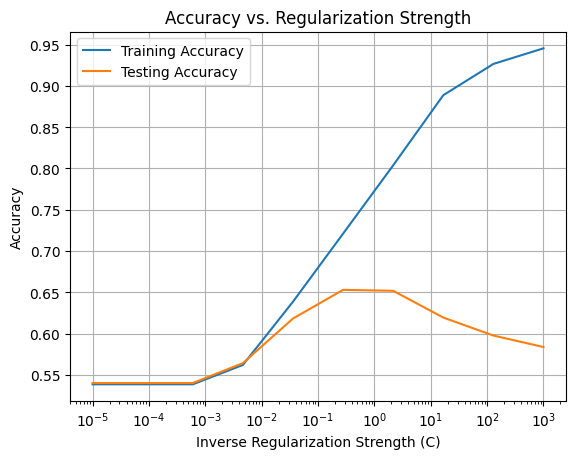

In [ ]:
plot_accuracy_vs_regularization(regularization_values, train_acc, test_acc)

In [12]:
# Training the optimal logistic regression model without scaling
optimal_lr = LogisticRegression(C=0.1, max_iter=1000, solver='lbfgs')
optimal_lr.fit(X_train, y_train)

# Evaluating the best model on the test set
y_test_pred = optimal_lr.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("Detailed Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Set Accuracy: 0.6369380315917376
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.49      0.56      5679
           1       0.64      0.76      0.69      6666

    accuracy                           0.64     12345
   macro avg       0.64      0.63      0.62     12345
weighted avg       0.64      0.64      0.63     12345



## Word2Vec

In [13]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 23.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [14]:
import spacy
nlp = spacy.load('en_core_web_md')

In [15]:
X = df["clean_text"].apply(lambda x: nlp(x).vector).to_numpy()
X = np.vstack(X)  # stacking the vectors into a 2D array
y = df["is_hate"]

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Function to tune Logistic Regression with different regularization strengths
def tune_lr(X_train, X_test, y_train, y_test, reg_params):
    train_acc = []
    test_acc = []

    for c in reg_params:
        # Training Logistic Regression with given regularization parameter C
        model = LogisticRegression(C=c, max_iter=1000, solver="lbfgs")
        model.fit(X_train, y_train)

        # evaluating on train and test sets
        train_acc.append(accuracy_score(y_train, model.predict(X_train)))
        test_acc.append(accuracy_score(y_test, model.predict(X_test)))

    return train_acc, test_acc

In [17]:
# Tuning the inversed regularization strength of logistic regression
reg_params = np.logspace(-5, 3, 10)
train_acc, test_acc = tune_lr(X_train, X_test, y_train, y_test, reg_params)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


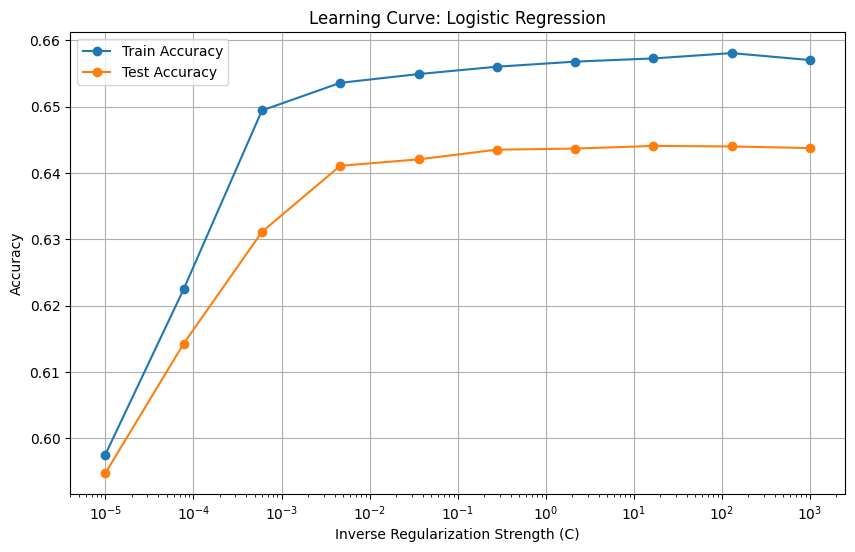

In [18]:
# The learning curve
def plot_learning_curve(reg_params, train_acc, test_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(reg_params, train_acc, label="Train Accuracy", marker="o")
    plt.plot(reg_params, test_acc, label="Test Accuracy", marker="o")
    plt.xscale("log")  # using a logarithmic scale for regularization parameters
    plt.xlabel("Inverse Regularization Strength (C)")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve: Logistic Regression")
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curve(reg_params, train_acc, test_acc)

In [19]:
# detailed analysis for the best model
best_lr = LogisticRegression(C=0.001)
best_lr.fit(X_train, y_train)

y_pred = best_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6345889023896314
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.54      0.58      5679
           1       0.65      0.72      0.68      6666

    accuracy                           0.63     12345
   macro avg       0.63      0.63      0.63     12345
weighted avg       0.63      0.63      0.63     12345



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## BERT-based model

In [20]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from torch.optim import Adam
from torch.nn import functional as F
from tqdm.notebook import tqdm

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
# Limiting dataset size for faster training
df_sample = df.sample(n=500, random_state=42)  # only 500 samples for training/testing
X_train, X_test, y_train, y_test = train_test_split(
    df_sample["clean_text"],
    df_sample["is_hate"],
    test_size=0.3,
    random_state=42
)

In [23]:
# Tokenizing text
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=64, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=64, return_tensors="pt")

In [24]:
# Convert to PyTorch Dataset
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [25]:
train_dataset = HateSpeechDataset(train_encodings, list(y_train))
test_dataset = HateSpeechDataset(test_encodings, list(y_test))

In [26]:
# Initializing model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Optimizer with reduced learning rate
optimizer = Adam(model.parameters(), lr=2e-5)

# variables to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 4
best_val_loss = float("inf")

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        # Predictions for accuracy
        predictions = torch.argmax(outputs.logits, dim=1)
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"]

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            # Predictions for accuracy
            predictions = torch.argmax(outputs.logits, dim=1)
            correct_val += (predictions == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

    # saving the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved Best Model!")

print("Training completed.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
Training Loss: 0.7065 | Training Accuracy: 0.5400
Validation Loss: 0.6782 | Validation Accuracy: 0.5933
Saved Best Model!
Epoch 2
Training Loss: 0.6834 | Training Accuracy: 0.5343
Validation Loss: 0.6704 | Validation Accuracy: 0.5933
Saved Best Model!
Epoch 3
Training Loss: 0.6227 | Training Accuracy: 0.6886
Validation Loss: 0.6500 | Validation Accuracy: 0.6667
Saved Best Model!
Epoch 4
Training Loss: 0.4399 | Training Accuracy: 0.8314
Validation Loss: 0.8185 | Validation Accuracy: 0.6333
Training completed.


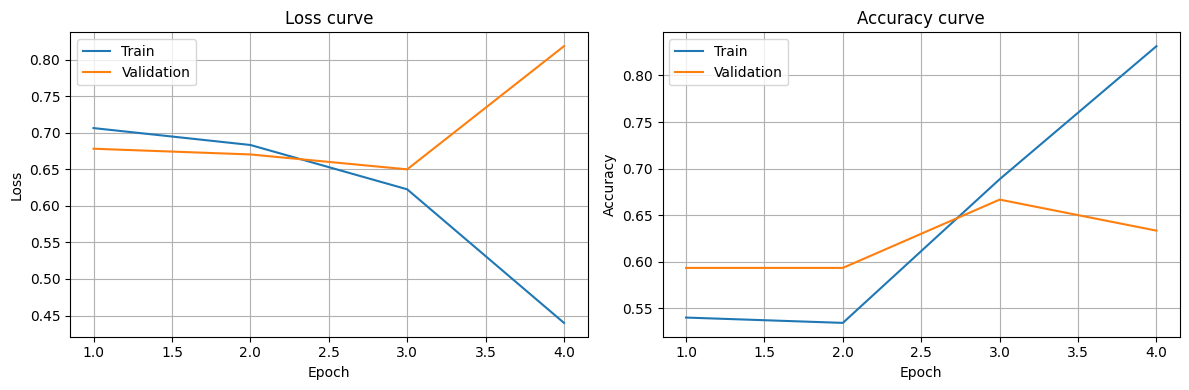

In [27]:
# Plotting Loss and Accuracy Curves
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax[0].grid()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss curve")
sns.lineplot(x=range(1, epochs + 1), y=train_losses, ax=ax[0], label="Train")
sns.lineplot(x=range(1, epochs + 1), y=val_losses, ax=ax[0], label="Validation")
ax[0].legend()

# Accuracy curve
ax[1].grid()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy curve")
sns.lineplot(x=range(1, epochs + 1), y=train_accuracies, ax=ax[1], label="Train")
sns.lineplot(x=range(1, epochs + 1), y=val_accuracies, ax=ax[1], label="Validation")
ax[1].legend()

plt.tight_layout()
plt.show()

In [28]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.tolist())
        y_pred.extend(predictions.tolist())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.90      0.66        59
           1       0.88      0.46      0.60        91

    accuracy                           0.63       150
   macro avg       0.70      0.68      0.63       150
weighted avg       0.74      0.63      0.63       150



### Analyzing the model output on a text sample

In [37]:
# Define sigmoid function for converting logits to probabilities
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Load the tokenizer and trained model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load("best_model.pt", map_location=torch.device('cpu')))  # loading weights
model.eval()  # Setting model to evaluation mode

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [69]:
# text for evaluation
text_to_explain = "Arabs are not welcome"

# Tokenizing the input
tokens = tokenizer(text_to_explain, return_tensors="pt", truncation=True, padding=True)

In [70]:
# model predictions
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits  # Raw model predictions (before activation)
    probs = sigmoid(logits.numpy())  # Converting logits to probabilities

# the results
print(f"Input Text: {text_to_explain}")
print(f"Probability of HATE: {probs[0][1]:.4f}")
print(f"Probability of NON-HATE: {probs[0][0]:.4f}")

Input Text: Arabs are not welcome
Probability of HATE: 0.5549
Probability of NON-HATE: 0.3508
